In [1]:
import numpy as np
import torch
import pickle

import sys
sys.path.append('../figures')

import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import adjust_spines

### Load dataset

In [2]:
def preprocess(data, slice_idx, loc_features_idx):
    X = data['Firing rate']
    X = X[slice_idx,:] # select the time slice
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X = X - X_mean
    X = X / X_std

    Y = data['Locomotion']
    Y = Y[slice_idx,:] # select the time slice
    Y = Y[:,loc_features_idx] # select the locomotion features
    Y_mean = np.mean(Y, axis=0)
    Y_std = np.std(Y, axis=0)
    Y = Y - Y_mean
    Y = Y / Y_std
    
    return X,Y, X_mean, X_std, Y_mean, Y_std 

In [3]:
data = pickle.load(open('../data/purkinje_extended_full.pickle', 'rb'))
locomotion_names = data['locomotion_names']
cell_names = data['cell_names']

Not all time points, not all locomotion features:

In [5]:
slice = np.linspace(0, 500000, 500000, dtype=int)
selected_features = [5,6,7,8,9,10,11,12,-8,-7,-6,-5,-4,-3,-2,-1] # locomotion features to use
np.array(locomotion_names)[selected_features]

array(['X-p FR', 'X-p HR', 'X-p FL', 'X-p HL', 'X-s FR', 'X-s HR',
       'X-s FL', 'X-s HL', 'Z-p FR', 'Z-p HR', 'Z-p FL', 'Z-p HL',
       'Z-s FR', 'Z-s HR', 'Z-s FL', 'Z-s HL'], dtype='<U11')

In [6]:
X_tr,Y_tr, X_tr_mean, X_tr_std, Y_tr_mean, Y_tr_std = preprocess(data, slice, selected_features)
print('Shape of X:', X_tr.shape, '\nShape of Y:', Y_tr.shape)

Shape of X: (500000, 105) 
Shape of Y: (500000, 16)


In [7]:
n_bins=X_tr.shape[0]
bin_size = 1/333*1000 # ms
bin_size

3.003003003003003

### Make GPFA format:

In [8]:
seqs = [(n_bins, X_tr.T)]
seqs = np.array(seqs, dtype=[('T', int), ('y', 'O')])

In [9]:
seqs[0]['y'].shape # (n_neurons, n_bins)

(105, 500000)

### GPFA:

**Note**: changed $\tau_{init}$ to $10 ms$ ! 

In [10]:
latent_dimensionality=2
min_var_frac=0.01
min_var_frac_explanation="""fraction of overall data variance for each observed dimension to set as
        the private variance floor.  This is used to combat Heywood cases,
        where ML parameter learning returns one or more zero private variances.
        Default: 0.01
        (See Martin & McDonald, Psychometrika, Dec 1975.)"""


tau_init=10 # ms # GP timescale initialization in msec
eps_init=1.0e-3 # GP noise variance initialization
em_tol=1.0e-8 # stopping criterion for EM
em_max_iters=500 # max EM iterations
freq_ll=5 # every freq_ll steps in EM likelihood is computed
verbose=False # feedback or not

bin_width=bin_size # ms

In [11]:
# Check if training data covariance is full rank
y_all = np.hstack(seqs["y"])
y_dim = y_all.shape[0]

if np.linalg.matrix_rank(np.cov(y_all)) < y_dim:
    errmesg = (
        "Observation covariance matrix is rank deficient.\n"
        "Possible causes: "
        "repeated units, not enough observations."
    )
    raise ValueError(errmesg)

### GPFA

We run gpfa, based on core implementation in [elephant](https://elephant.readthedocs.io/en/latest/reference/gpfa.html), but without using Neo spike train preprocessing.

In [12]:
from elephant.gpfa import gpfa_core

In [ ]:
# The following does the heavy lifting.
params_estimated, fit_info = gpfa_core.fit(
    seqs_train=seqs,
    x_dim=latent_dimensionality,
    bin_width=bin_width,
    min_var_frac=min_var_frac,
    em_max_iters=em_max_iters,
    em_tol=em_tol,
    tau_init=tau_init,
    eps_init=eps_init,
    freq_ll=freq_ll,
    verbose=verbose
)

Initializing parameters using factor analysis...

Fitting GPFA model...


And now transform:

Obtain trajectories of neural activity in a low-dimensional latent
variable space by inferring the posterior mean of the obtained GPFA
model and applying an orthonormalization on the latent variable space.

In [14]:
transform_info = dict()
returned_data=['latent_variable', 'VsmGP']

In [ ]:
Y_test = data['Locomotion'][500000:5010000,:]
Y_test = Y_test[:,selected_features]
X_test = data['Firing rate'][500000:5010000,:]
X_test = X_test - X_tr_mean
X_test = X_test / X_tr_std
Y_test = Y_test - Y_tr_mean
Y_test = Y_test / Y_tr_std

In [ ]:
n_bins=X_test.shape[0]
seqs = [(n_bins, X_test.T)]
seqs = np.array(seqs, dtype=[('T', int), ('y', 'O')])

In [ ]:
seqs, ll = gpfa_core.exact_inference_with_ll(
    seqs, params_estimated, get_ll=True
)

In [16]:
ll

-1060630.8486611433

seqs has been augmented with latents, Vsm, and VsmGP (GP posterior over time)

In [17]:
seqs.dtype.names

('T', 'y', 'latent_variable', 'Vsm', 'VsmGP')

In [18]:
seqs[0]['y'].shape

(105, 10000)

In [20]:
seqs[0]['latent_variable'].shape

(2, 10000)

In [21]:
latents=seqs[0]['latent_variable']

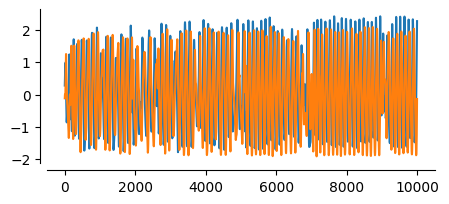

In [46]:
fig, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(latents[0,:])
ax.plot(latents[1,:])
adjust_spines(ax, ['left', 'bottom'])

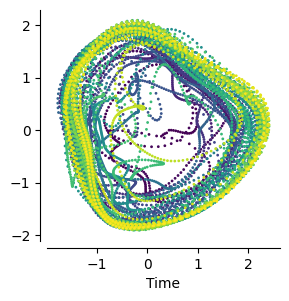

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(latents[0,:], latents[1,:], c=range(10000), cmap='viridis', s=1)
ax.set_xlabel("Time")
adjust_spines(ax, ['bottom', 'left'])

In [24]:
seqs[0]['Vsm'].shape

(2, 2, 10000)

In [25]:
seqs[0]['VsmGP'].shape

(10000, 10000, 2)

In [26]:
transform_info["log_likelihood"] = ll
transform_info["num_bins"] = seqs["T"]

Orthonormalize latent space.

In [27]:
Corth, seqs = gpfa_core.orthonormalize(params_estimated, seqs)

In [28]:
transform_info["Corth"] = Corth
if len(returned_data) == 1:
    gpfa_val_result = seqs[returned_data[0]]
gpfa_val_result =  {x: seqs[x] for x in returned_data}

In [29]:
gpfa_val_result.keys()

dict_keys(['latent_variable', 'VsmGP'])

In [30]:
params_estimated.keys()

dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes', 'Corth'])

In [31]:
params_estimated['gamma']

array([0.00330327, 0.00387632])

In [32]:
with open('../pickles/purkinje_gpfa_train.pickle', 'wb') as f:
    pickle.dump({
        'params':params_estimated,
        'latents':gpfa_val_result
    }, f)

In [33]:
length_scales = params_estimated['gamma']
params_estimated.keys()

dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes', 'Corth'])

In [34]:
length_scales.shape

(2,)

In [37]:
C = params_estimated['C']
C.shape

(105, 2)

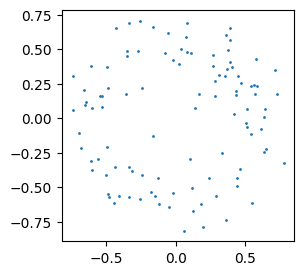

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(C[:,0], C[:,1], s=1)

In [48]:
length_scales

array([0.00330327, 0.00387632])

### Additional possible analyses:

#### Estimate readouts, decode trajectories from latents

In [71]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [58]:
def estimate_readout_matrix(Y, m, P, delta, n_iter=2500):
    n_trials = Y.shape[0]
    n_neuron = Y.shape[2]
    n_latent = m.shape[2]
    n_time_bins = Y.shape[1]
    M = torch.zeros((n_trials, n_time_bins, n_latent))
    C_hat = torch.nn.Linear(n_latent, n_neuron, bias=True)

    for n in range(n_trials):
        if (torch.is_tensor(m)):
            M[n] = torch.tensor(m[n].detach().clone())
        else:
            M[n] = torch.tensor(m[n])

    opt = torch.optim.Adam(C_hat.parameters(), lr=1e-2)
    loss_log = []

    for i in range(n_iter):
        log_r = C_hat(M)
        ell = torch.tensor(Y) * log_r - delta * torch.exp(log_r)
        loss = -1 * torch.sum(ell)

        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_log.append(loss.item())

    return C_hat, loss_log

In [66]:
readout_iter=1000
C_hat, loss_log = estimate_readout_matrix(
    seqs[0]['y'].T[np.newaxis,:,:],
    latents.T[np.newaxis,:,:],
    None,
    bin_size,
    readout_iter
    )

In [60]:
gpfa_val_result['latent_variable'][0].shape

(2, 10000)

In [62]:
C_hat.weight.data.shape

torch.Size([105, 2])

In [70]:
C_hat(torch.as_tensor(latents,dtype=torch.float32).T).shape

torch.Size([10000, 105])

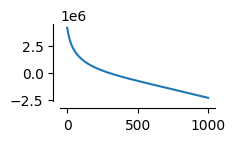

In [67]:
fig, ax = plt.subplots(1,1,figsize=(2,1))
ax.plot(loss_log)
sns.despine()
adjust_spines(ax,['bottom', 'left'])

In [73]:
latents.T.shape

(10000, 2)

In [74]:
Y_tr.shape

(10000, 16)

In [75]:
z=latents.T
b=Y_test

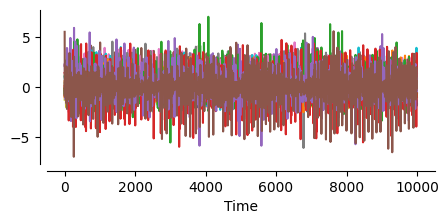

In [76]:
fig, ax = plt.subplots(1, 1, figsize =(5,2))

for b_dim in range(0,b.shape[1]):
    plt.plot(
        range(0,b.shape[0]),
        b[:,b_dim]
    )
ax.set_xlabel("Time")
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

In [77]:
gscv_GPFA = GridSearchCV(Ridge(), {'alpha': np.logspace(-7, -1, 100)})

In [78]:
gscv_GPFA.fit(z, b)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-07, 1.14975700e-07, 1.32194115e-07, 1.51991108e-07,
       1.74752840e-07, 2.00923300e-07, 2.31012970e-07, 2.65608778e-07,
       3.05385551e-07, 3.51119173e-07, 4.03701726e-07, 4.64158883e-07,
       5.33669923e-07, 6.13590727e-07, 7.05480231e-07, 8.11130831e-07,
       9.32603347e-07, 1.07226722e-06, 1.23284674e-06, 1.41747...
       4.03701726e-03, 4.64158883e-03, 5.33669923e-03, 6.13590727e-03,
       7.05480231e-03, 8.11130831e-03, 9.32603347e-03, 1.07226722e-02,
       1.23284674e-02, 1.41747416e-02, 1.62975083e-02, 1.87381742e-02,
       2.15443469e-02, 2.47707636e-02, 2.84803587e-02, 3.27454916e-02,
       3.76493581e-02, 4.32876128e-02, 4.97702356e-02, 5.72236766e-02,
       6.57933225e-02, 7.56463328e-02, 8.69749003e-02, 1.00000000e-01])})

In [79]:
b_hat = gscv_GPFA.predict(z)

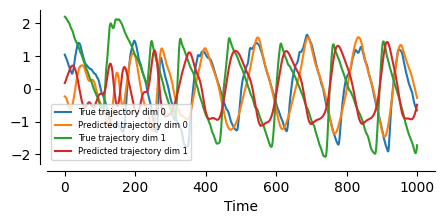

In [85]:
fig, ax = plt.subplots(1, 1, figsize =(5,2))

for b_dim in range(0,2):
    ax.plot(
        range(0,1000),
        b[:1000,b_dim],
        label='True trajectory dim {}'.format(b_dim)
    )
    ax.plot(
        range(0,1000),
        b_hat[:1000,b_dim],
        label='Predicted trajectory dim {}'.format(b_dim)
    )
ax.legend(loc='best', fontsize=6)
ax.set_xlabel("Time")
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

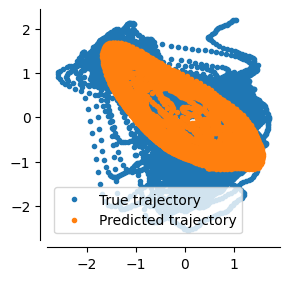

In [86]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(b[:,0],b[:,1], '.', label='True trajectory')
ax.plot(b_hat[:,0],b_hat[:,1], '.', label='Predicted trajectory')
ax.legend(loc='best')
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

R^2 score:

In [87]:
np.mean(1-np.sum((b-b_hat)**2, axis=1)/np.sum((b-b.mean(axis=0))**2,axis=1))

0.416790154543897